In [1]:
#useful packages
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

#### Informazioni relative al dataset

Ci si concentra per il momento su uno dei tre set di misure simulate, ovvero Test 1

In [5]:
fname='data/MockMeasures_2PCF_Test1/MockMeasures_2PCF_Correlation_MULTIPOLES_Test1_1.fits'

In [6]:
file=fits.open(fname)

L'header contiene le informazioni relative al dataset:

In [7]:
file[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   48 / width of table in bytes                        
NAXIS2  =                  200 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    6 / number of fields in each row                   
EXTNAME = 'CORRELATION'        / name of this binary table extension            
DATE    = '2021-10-11T15:20:58' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
CHECKSUM= '11PD40N910NC10N9'   / HDU checksum updated 2021-10-11T15:20:58       
DATASUM = '3493986317'         / data unit checksum updated 2021-10-11T15:20:58 
TELESCOP= 'EUCLID  '        

Per il processo di lettura dei dati di interesse è utile visualizzare in modo esplicito come sono organizzati nel file:

In [8]:
file[1].data

FITS_rec([(  0.59975,  8.54205150e+00, 0., -3.44217353e+00, 0., -3.05878863e+00),
          (  1.59925,  2.89127955e+00, 0., -5.54919428e-01, 0., -8.97318156e-01),
          (  2.59875,  1.51079053e+00, 0., -2.18552188e-01, 0., -3.49992133e-01),
          (  3.59825,  9.58324561e-01, 0., -1.17000828e-01, 0., -1.31833928e-01),
          (  4.59775,  6.68471660e-01, 0., -8.96877154e-02, 0., -1.52346569e-01),
          (  5.59725,  4.98214450e-01, 0., -9.94204219e-02, 0., -9.31585195e-02),
          (  6.59675,  3.90214392e-01, 0., -2.82246323e-02, 0., -5.29329306e-02),
          (  7.59625,  2.99754650e-01, 0., -6.91685268e-02, 0., -8.83656107e-02),
          (  8.59575,  2.49860708e-01, 0., -4.73030365e-02, 0., -5.44634927e-02),
          (  9.59525,  1.97435768e-01, 0., -6.22467439e-02, 0., -8.51734824e-02),
          ( 10.59475,  1.75106286e-01, 0., -4.41889582e-02, 0., -4.15635943e-02),
          ( 11.59425,  1.41045038e-01, 0., -3.94166804e-02, 0., -3.87499395e-02),
          ( 12.5

### Test 1

#### Multipolo 0

##### Lettura dati

In [8]:
#lunghezza del vettore di dati
Nbins = 200 

#numero di misure
Nmeasures = 1000

test = 1

measures=[]
distance=[]

for i in np.arange(Nmeasures)+1:
    fname = f'data/MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_Multipoles_Test{test}_{i}.fits'   
    
    file=fits.open(fname)
    table=file[1].data.copy()
    measures.append(table['XI0'])
    
    if i==1:
        distance.append(table['SCALE'])
    del table
    file.close()

measures=np.asarray(measures).transpose()
distance=np.asarray(distance).transpose()

##### Valori di media e covarianza tramite librerie numpy

In [10]:
mean = np.mean(measures, axis=1)
cov = np.cov(measures)

##### Valori di media e covarianza calcolati manualmente 

In [13]:
mean_man = np.zeros((Nbins), dtype=float)
cov_man = np.zeros((Nbins, Nbins), dtype=float)

mean_man = np.sum(measures, axis=1)/Nmeasures

for i in range(Nbins):
    for j in range(Nbins):
        
        cov_man[i,j] = 1/(Nmeasures-1)*np.sum((measures[i]-mean_man[i])*(measures[j]-mean_man[j]))

Valuto la differenza dei valori ottenuti per ciascun metodo

In [14]:
print('Massima differenza nella media = ', np.max(np.abs(mean-mean_man)))
print('Massima differenza nella covarianza = ', np.max(np.abs(cov-cov_man)))

Massima differenza nella media =  0.0
Massima differenza nella covarianza =  2.710505431213761e-19


##### Covarianza teorica

In [15]:
sigma = 0.02
h = 25

cov_th = np.zeros((Nbins, Nbins), dtype=float)

for i in range(Nbins):
    for j in range(Nbins):
        
        cov_th[i,j] = sigma**2*(np.exp(-(distance[i]-distance[j])**2/(2*h**2)))

##### Calcolo delle matrici di correlazione nei due casi

In [16]:
corr = np.zeros((Nbins,Nbins), dtype=float)
corr_man = np.zeros((Nbins,Nbins), dtype=float)

for i in range(Nbins):
    for j in range(Nbins):
        corr[i,j] = cov[i,j]/np.sqrt((cov[i,i]*cov[j,j]))
        corr_man[i,j] = cov_man[i,j]/np.sqrt((cov_man[i,i]*cov_man[j,j]))

##### Calcolo dei residui e confronto

In [17]:
res = np.zeros((Nbins,Nbins), dtype=float)
res_man = np.zeros((Nbins,Nbins), dtype=float)

for i in range(Nbins):
    for j in range(Nbins):
        res[i,j] = (cov_th[i,j]-cov[i,j])*np.sqrt((Nmeasures-1)/((1+corr[i,j])*cov_th[i,i]*cov_th[j,j]))
        res_man[i,j] = (cov_th[i,j]-cov_man[i,j])*np.sqrt((Nmeasures-1)/((1+corr_man[i,j])*cov_th[i,i]*cov_th[j,j]))
        
#verifico che siano distribuzioni normali standard
print('residui con calcolo da libreria')
print('media : ',np.mean(res))
print('varianza : ',np.var(res))
print('-------------------------------------')
print('residui con calcolo manuale')
print('media',np.mean(res_man))
print('varianza',np.var(res_man))

residui con calcolo da libreria
media :  0.5579229984495769
varianza :  0.6445655957411588
-------------------------------------
residui con calcolo manuale
media 0.5579229984495769
varianza 0.6445655957411589


##### Grafici

In [18]:
def plotdiagram(q, title):
    gratio = (1. + np.sqrt(5.))/2.
    dpi = 300
    qmin=-np.max(q)*0.05
    qmax=np.max(q)*1.05

    fig=plt.figure(figsize=(6,4))
    plt.title(title)
    plt.imshow(q, vmin=qmin, vmax=qmax)
    cbar=plt.colorbar(orientation='vertical', pad=0.02)
    plt.show()

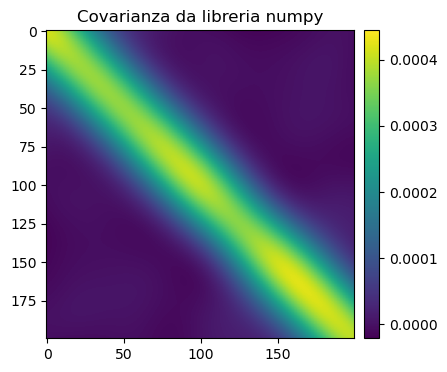

In [19]:
plotdiagram(cov, 'Covarianza da libreria numpy')

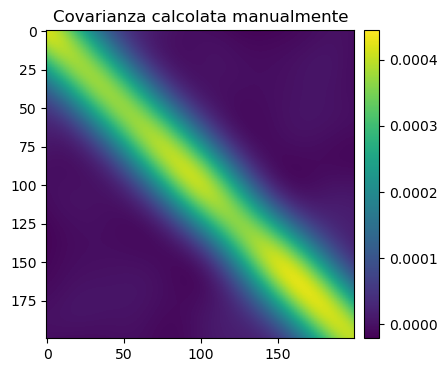

In [20]:
plotdiagram(cov_man, 'Covarianza calcolata manualmente')

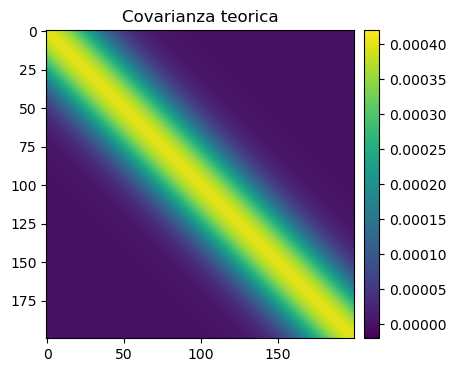

In [21]:
plotdiagram(cov_th, 'Covarianza teorica')

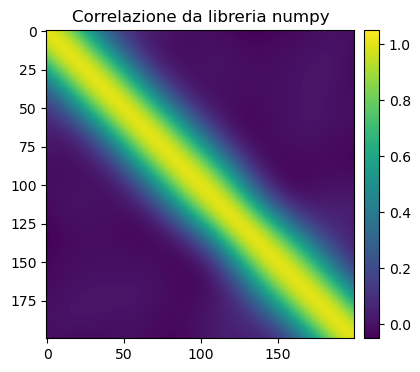

In [22]:
plotdiagram(corr, 'Correlazione da libreria numpy')

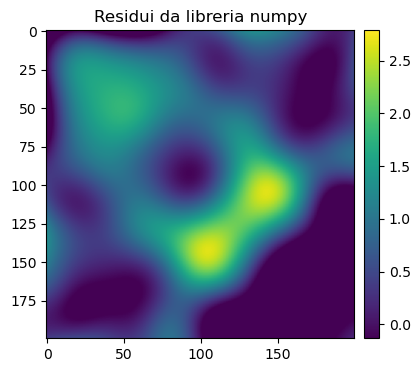

In [23]:
plotdiagram(res, 'Residui da libreria numpy')

#### Estensione ai tre multipoli pari

Viene ripetuto il calcolo delle quantità del caso di singolo multipolo, semplicemente applicandolo ad una matrice measures più estesa, che comprende cioè i dati per tre multipoli anziché uno solo.

In [24]:
measures0=[]
measures2=[]
measures4=[]
measures=[]


for i in np.arange(Nmeasures)+1:
    fname = f'data/MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_Multipoles_Test{test}_{i}.fits'   
    
    file=fits.open(fname)
    table=file[1].data.copy()
    
    measures0.append(table['XI0'])
    measures2.append(table['XI2'])
    measures4.append(table['XI4'])
    
    del table
    file.close()

measures0=np.asarray(measures0).transpose()
measures2=np.asarray(measures2).transpose()
measures4=np.asarray(measures4).transpose()
measures = np.concatenate((measures0, measures2, measures4))

In [25]:
distance = np.concatenate((distance, distance, distance))

In [34]:
Nbins=600

In [35]:
mean = np.mean(measures, axis=1)
cov = np.cov(measures)

In [36]:
mean_man = np.zeros((Nbins), dtype=float)
cov_man = np.zeros((Nbins, Nbins), dtype=float)

mean_man = np.sum(measures, axis=1)/Nmeasures

for i in range(Nbins):
    for j in range(Nbins):
        
        cov_man[i,j] = 1/(Nmeasures-1)*np.sum((measures[i]-mean_man[i])*(measures[j]-mean_man[j]))

In [37]:
sigma = 0.02
h = [25, 50, 75]
k = [0, 1./3, 2./3, 1.]

cov_th = np.zeros((Nbins, Nbins), dtype=float)

for m in range(1,4):
    for n in range(1,4):
        for i in range(int(Nbins*k[m-1]),int(Nbins*k[m])):
            for j in range(int(Nbins*k[n-1]),int(Nbins*k[n])):
            
                cov_th[i,j] = sigma**2*np.sqrt((2*h[m-1]*h[n-1])/(h[m-1]**2 + h[n-1]**2))*(np.exp(-(distance[i]-distance[j])**2/(h[m-1]**2 + h[n-1]**2)))                

In [38]:
corr = np.zeros((Nbins,Nbins), dtype=float)
corr_man = np.zeros((Nbins,Nbins), dtype=float)

for i in range(Nbins):
    for j in range(Nbins):
        corr[i,j] = cov[i,j]/np.sqrt((cov[i,i]*cov[j,j]))
        corr_man[i,j] = cov_man[i,j]/np.sqrt((cov_man[i,i]*cov_man[j,j]))

In [39]:
res = np.zeros((Nbins,Nbins), dtype=float)
res_man = np.zeros((Nbins,Nbins), dtype=float)

for i in range(Nbins):
    for j in range(Nbins):
        res[i,j] = (cov_th[i,j]-cov[i,j])*np.sqrt((Nmeasures-1)/((1+corr[i,j])*cov_th[i,i]*cov_th[j,j]))
        res_man[i,j] = (cov_th[i,j]-cov_man[i,j])*np.sqrt((Nmeasures-1)/((1+corr_man[i,j])*cov_th[i,i]*cov_th[j,j]))

In [41]:
#verifico che siano distribuzioni normali standard
print('residui con calcolo da libreria')
print('media : ',np.mean(res))
print('varianza : ',np.var(res))
print('-------------------------------------')
print('residui con calcolo manuale')
print('media : ',np.mean(res_man))
print('varianza : ',np.var(res_man))

residui con calcolo da libreria
media :  0.8595623800662805
varianza :  0.5065762886313512
-------------------------------------
residui con calcolo manuale
media :  0.8595623800662805
varianza :  0.5065762886313512


### Grafici

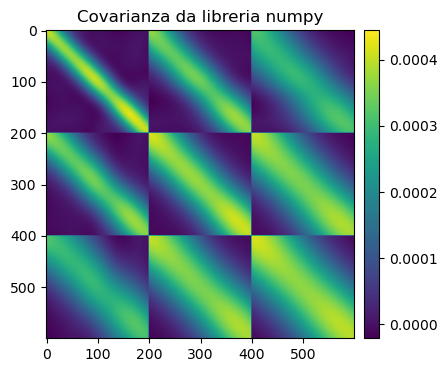

In [42]:
plotdiagram(cov, 'Covarianza da libreria numpy')

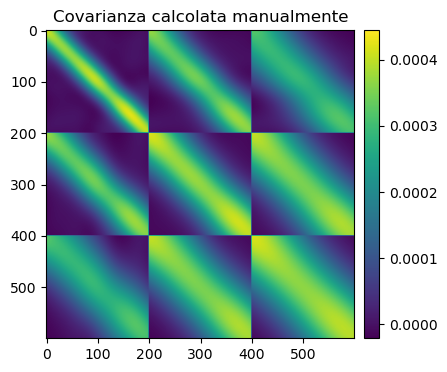

In [43]:
plotdiagram(cov_man, 'Covarianza calcolata manualmente')

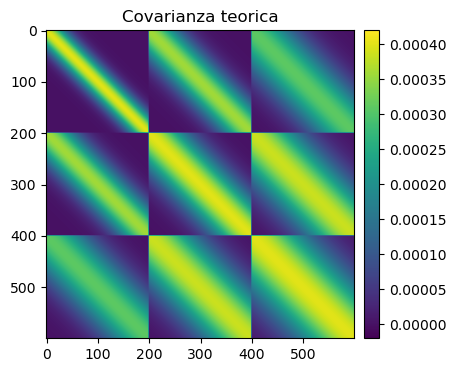

In [44]:
plotdiagram(cov_th, 'Covarianza teorica')

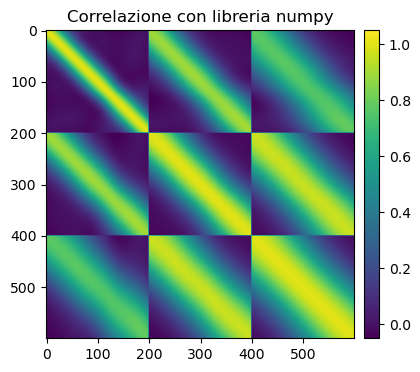

In [45]:
plotdiagram(corr, 'Correlazione con libreria numpy')

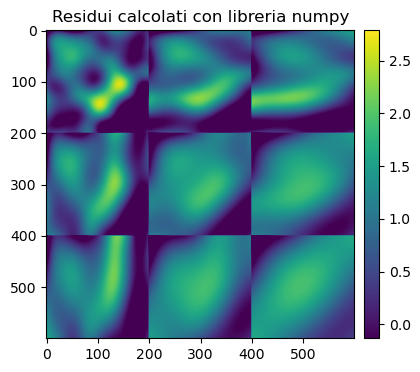

In [46]:
plotdiagram(res, 'Residui calcolati con libreria numpy')

## Test 2

Si ripete il procedimento di Test 1, considerando direttamente i tre multipoli pari anziché passare per il caso di multipolo singolo

In [50]:
test = 2

measures0=[]
measures2=[]
measures4=[]
measures=[]
distance=[]

for i in np.arange(Nmeasures)+1:
    fname = f'data/MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_Multipoles_Test{test}_{i}.fits'   
    
    file=fits.open(fname)
    table=file[1].data.copy()
    measures0.append(table['XI0'])
    measures2.append(table['XI2'])
    measures4.append(table['XI4'])
    
    
    if i==1:
        distance.append(table['SCALE'])
    del table
    file.close()
    
measures0=np.asarray(measures0).transpose()
measures2=np.asarray(measures2).transpose()
measures4=np.asarray(measures4).transpose()
measures = np.concatenate((measures0, measures2, measures4))

distance=np.asarray(distance).transpose()
distance = np.concatenate((distance, distance, distance))

In [51]:
mean = np.mean(measures, axis=1)
cov = np.cov(measures)

In [52]:
mean_man = np.zeros((Nbins), dtype=float)
cov_man = np.zeros((Nbins, Nbins), dtype=float)

mean_man = np.sum(measures, axis=1)/Nmeasures

for i in range(Nbins):
    for j in range(Nbins):
        
        cov_man[i,j] = 1/(Nmeasures-1)*np.sum((measures[i]-mean_man[i])*(measures[j]-mean_man[j]))

In [53]:
sigma = [0.02, 0.01, 0.005]
h = 50
k = [0, 1./3, 2./3, 1.]

cov_th = np.zeros((Nbins, Nbins), dtype=float)

for m in range(1,4):
    for n in range(1,4):
        for i in range(int(Nbins*k[m-1]),int(Nbins*k[m])):
            for j in range(int(Nbins*k[n-1]),int(Nbins*k[n])):
            
                cov_th[i,j] = sigma[m-1]*sigma[n-1]*np.exp(-(distance[i]-distance[j])**2/(2*h**2))
                

In [54]:
corr = np.zeros((Nbins,Nbins), dtype=float)
corr_man = np.zeros((Nbins,Nbins), dtype=float)

for i in range(Nbins):
    for j in range(Nbins):
        corr[i,j] = cov[i,j]/np.sqrt((cov[i,i]*cov[j,j]))
        corr_man[i,j] = cov_man[i,j]/np.sqrt((cov_man[i,i]*cov_man[j,j]))

In [55]:
res = np.zeros((Nbins,Nbins), dtype=float)
res_man = np.zeros((Nbins,Nbins), dtype=float)

for i in range(Nbins):
    for j in range(Nbins):
        res[i,j] = (cov_th[i,j]-cov[i,j])*np.sqrt((Nmeasures-1)/((1+corr[i,j])*cov_th[i,i]*cov_th[j,j]))
        res_man[i,j] = (cov_th[i,j]-cov_man[i,j])*np.sqrt((Nmeasures-1)/((1+corr_man[i,j])*cov_th[i,i]*cov_th[j,j]))

In [57]:
#verifico che siano distribuzioni normali standard
print('residui con calcolo da libreria')
print('media : ',np.mean(res))
print('varianza : ',np.var(res))
print('-------------------------------------')
print('residui con calcolo manuale')
print('media : ',np.mean(res_man))
print('varianza : ',np.var(res_man))

residui con calcolo da libreria
media :  -1.2896895914204178
varianza :  0.5272253932858328
-------------------------------------
residui con calcolo manuale
media :  -1.2896895914204178
varianza :  0.527225393285833


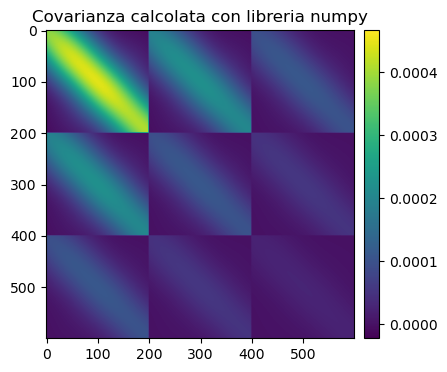

In [58]:
plotdiagram(cov, 'Covarianza calcolata con libreria numpy')

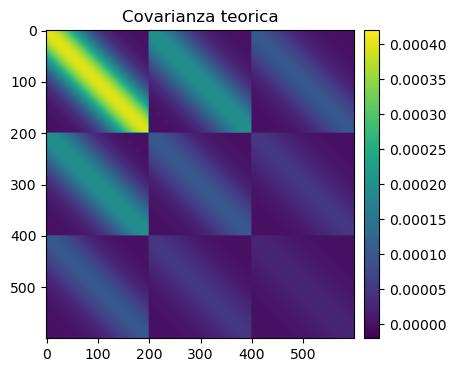

In [59]:
plotdiagram(cov_th, 'Covarianza teorica')

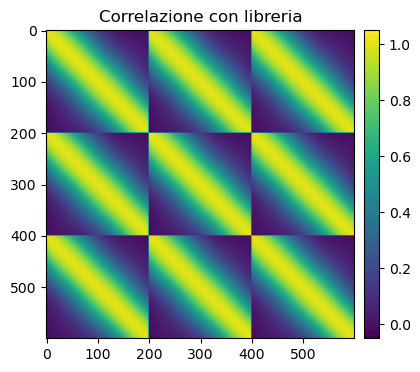

In [60]:
plotdiagram(corr, 'Correlazione con libreria')

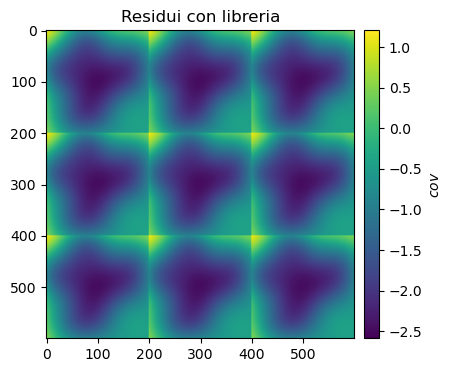

In [61]:
gratio = (1. + np.sqrt(5.))/2.
dpi = 300
cmin=np.min(res)*1.05
cmax=np.max(res)*1.05

fig=plt.figure(figsize=(6,4))
plt.title('Residui con libreria')
plt.imshow(res, vmin=cmin, vmax=cmax)
cbar=plt.colorbar(orientation='vertical', pad=0.02)
cbar.set_label(r'$ cov$')
plt.show()

### Test 3

Anche in questo caso si ripete il procedimento di Test 1 prendendo direttamente i tre multipoli pari

In [62]:
test = 3

measures0=[]
measures2=[]
measures4=[]
measures=[]
distance=[]

for i in np.arange(Nmeasures)+1:
    fname = f'data/MockMeasures_2PCF_Test{test}/MockMeasures_2PCF_Correlation_Multipoles_Test{test}_{i}.fits'   
    
    file=fits.open(fname)
    table=file[1].data.copy()
    measures0.append(table['XI0'])
    measures2.append(table['XI2'])
    measures4.append(table['XI4'])
    
    
    if i==1:
        distance.append(table['SCALE'])
    del table
    file.close()
    
measures0=np.asarray(measures0).transpose()
measures2=np.asarray(measures2).transpose()
measures4=np.asarray(measures4).transpose()
measures = np.concatenate((measures0, measures2, measures4))

distance=np.asarray(distance).transpose()
distance = np.concatenate((distance, distance, distance))

In [63]:
mean = np.mean(measures, axis=1)
cov = np.cov(measures)

In [64]:
mean_man = np.zeros((Nbins), dtype=float)
cov_man = np.zeros((Nbins, Nbins), dtype=float)

mean_man = np.sum(measures, axis=1)/Nmeasures

for i in range(Nbins):
    for j in range(Nbins):
        
        cov_man[i,j] = 1/(Nmeasures-1)*np.sum((measures[i]-mean_man[i])*(measures[j]-mean_man[j]))

In [65]:
sigma = [0.02, 0.01, 0.005]
h = 5
k = [0, 1./3, 2./3, 1.]

cov_th = np.zeros((Nbins, Nbins), dtype=float)

for m in range(1,4):
    for n in range(1,4):
        for i in range(int(Nbins*k[m-1]),int(Nbins*k[m])):
            for j in range(int(Nbins*k[n-1]),int(Nbins*k[n])):
            
                cov_th[i,j] = sigma[m-1]*sigma[n-1]*np.exp(-(distance[i]-distance[j])**2/(2*h**2))
                

In [66]:
corr = np.zeros((Nbins,Nbins), dtype=float)
corr_man = np.zeros((Nbins,Nbins), dtype=float)

for i in range(Nbins):
    for j in range(Nbins):
        corr[i,j] = cov[i,j]/np.sqrt((cov[i,i]*cov[j,j]))
        corr_man[i,j] = cov_man[i,j]/np.sqrt((cov_man[i,i]*cov_man[j,j]))

In [67]:
res = np.zeros((Nbins,Nbins), dtype=float)
res_man = np.zeros((Nbins,Nbins), dtype=float)

for i in range(Nbins):
    for j in range(Nbins):
        res[i,j] = (cov_th[i,j]-cov[i,j])*np.sqrt((Nmeasures-1)/((1+corr[i,j])*cov_th[i,i]*cov_th[j,j]))
        res_man[i,j] = (cov_th[i,j]-cov_man[i,j])*np.sqrt((Nmeasures-1)/((1+corr_man[i,j])*cov_th[i,i]*cov_th[j,j]))

In [68]:
#verifico che siano distribuzioni normali standard
print('residui con calcolo da libreria')
print('media : ',np.mean(res))
print('varianza : ',np.var(res))
print('-------------------------------------')
print('residui con calcolo manuale')
print('media : ',np.mean(res_man))
print('varianza : ',np.var(res_man))

residui con calcolo da libreria
media :  -0.00953159717065907
varianza :  1.0645343107027452
-------------------------------------
residui con calcolo manuale
media :  -0.009531597170659063
varianza :  1.0645343107027452


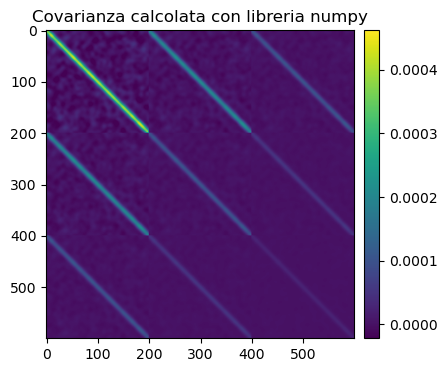

In [69]:
plotdiagram(cov, 'Covarianza calcolata con libreria numpy')

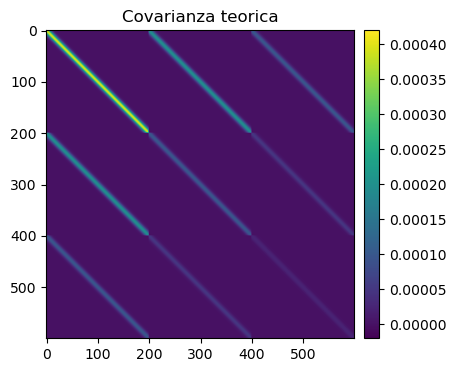

In [70]:
plotdiagram(cov_th, 'Covarianza teorica')

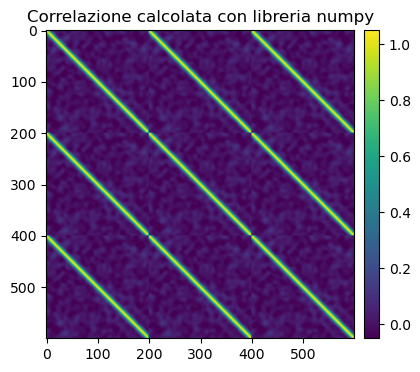

In [71]:
plotdiagram(corr, 'Correlazione calcolata con libreria numpy')

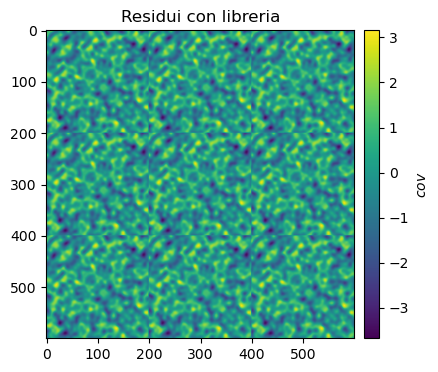

In [72]:
gratio = (1. + np.sqrt(5.))/2.
dpi = 300
cmin=np.min(res)*1.05
cmax=np.max(res)*1.05

fig=plt.figure(figsize=(6,4))
plt.title('Residui con libreria')
plt.imshow(res, vmin=cmin, vmax=cmax)
cbar=plt.colorbar(orientation='vertical', pad=0.02)
cbar.set_label(r'$ cov$')
plt.show()